### 1. Import Modules

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from tensorflow import keras

# download Punkt Sentence Tokenizer
nltk.download('punkt')
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Download and Load Dataset

In [2]:
# download IMDB dataset
!wget "https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv" -O "movie_data.csv"

# list files in current directory
!ls -lah

--2024-05-19 13:13:42--  https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862309 (63M) [text/plain]
Saving to: ‘movie_data.csv’

movie_data.csv      100%[===================>]  62.81M   284MB/s    in 0.2s    

2024-05-19 13:13:42 (284 MB/s) - ‘movie_data.csv’ saved [65862309/65862309]

total 63M
drwxr-xr-x 1 root root 4.0K May 19 12:54 .
drwxr-xr-x 1 root root 4.0K May 19 12:46 ..
drwxr-xr-x 4 root root 4.0K May 16 13:24 .config
-rw-r--r-- 1 root root  63M May 19 13:13 movie_data.csv
drwxr-xr-x 1 root root 4.0K May 16 13:24 sample_data


In [3]:
# the path to the IMDB dataset
dataset_path = 'movie_data.csv'

# read file (dataset) into our program using pandas
data = pd.read_csv(dataset_path)

# display first 5 rows
data.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def clean_review(text):
  # convert to lower case
  text = text.lower()

  # remove none alphabetic characters
  text = re.sub(r'[^a-z]', ' ', text)

  # stem words
  # split into words
  tokens = word_tokenize(text)

  # stemming of words
  stemmed = [stemmer.stem(word) for word in tokens]

  text = ' '.join(stemmed)

  # remove stopwords
  text = ' '.join([word for word in text.split() if word not in english_stopwords])

  return text


# apply to all dataset
data['clean_review'] = data['review'].apply(clean_review)
data.head()

,review,sentiment,clean_review
0,I went and saw this movie last night after bei...,1,went saw thi movi last night coax friend mine ...
1,Actor turned director Bill Paxton follows up h...,1,actor turn director bill paxton follow hi prom...
2,As a recreational golfer with some knowledge o...,1,recreat golfer knowledg sport histori wa pleas...
3,"I saw this film in a sneak preview, and it is ...",1,saw thi film sneak preview delight cinematogra...
4,Bill Paxton has taken the true story of the 19...,1,bill paxton ha taken true stori us golf open m...


### 4. Split Dataset

In [5]:
from sklearn.model_selection import train_test_split

X = data['clean_review'].values
y = data['sentiment'].values

# Split data into 50% training & 50% test
# let's all use a random state of 42 for example to ensure having the same split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# define your tokenizer (with num_words=10000)
tokenizer_obj = Tokenizer(num_words=10000)

# assign an index (number) to each word using fit_on_texts function
tokenizer_obj.fit_on_texts(x_train)

# will be used later to pad sequences
max_length = 120

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

# transform each text to a sequence of integers (to be used later in embeddings layer)
X_train_tokens =  tokenizer_obj.texts_to_sequences(x_train)
X_test_tokens =  tokenizer_obj.texts_to_sequences(x_test)


# apply post-padding to the sequences
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [7]:
x_train[0], X_train_pad[0]

('would reccomend thi film everyon onli fan rocker luciano ligabu film buff becaus sincer move funni true becaus ligabu born storytel film lover everi frame hi film made love care becaus hi charact love ask love becaus italian debut film lousi thi one done outsid real joy watch listen becaus stefano accorsi gorgeou remind andrea pazienza wa like freccia beauti talent good lost hi life becaus heroin ligabu show unglamor ugli without indulg easi moral becaus film speak heart ear soul becaus live experi fm radio wa exactli like thank luciano',
 array([  20,    2,    5,  239,   22,  130, 6148,    5, 2142,   34, 2075,
         203,   84,  224,   34, 1295, 2188,    5,  803,  101, 1136,    6,
           5,   42,   33,  241,   34,    6,   13,   33,  396,   33,   34,
         902, 1685,    5, 2060,    2,    7,  152,  886,   81, 1490,   16,
         923,   34, 1426,  627, 3992,    4,    8,  137,  320,   12,  391,
           6,   60,   34, 1453,   26, 1292,  139, 2273,  721,  837,   34,
         

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 300

# FILL BLANKS
# build the neural network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# compile model: assign loss & optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 300)          15439500  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 15659277 (59.74 MB)
Trainable params: 15659277 (59.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# train model
model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

Epoch 1/5
782/782 [==============================] - 64s 78ms/step - loss: 0.6072 - accuracy: 0.6704 - val_loss: 0.5251 - val_accuracy: 0.7650
Epoch 2/5
782/782 [==============================] - 20s 25ms/step - loss: 0.5298 - accuracy: 0.7365 - val_loss: 0.5391 - val_accuracy: 0.7474
Epoch 3/5
782/782 [==============================] - 18s 23ms/step - loss: 0.3596 - accuracy: 0.8498 - val_loss: 0.3549 - val_accuracy: 0.8405
Epoch 4/5
782/782 [==============================] - 17s 21ms/step - loss: 0.2395 - accuracy: 0.9079 - val_loss: 0.3317 - val_accuracy: 0.8668
Epoch 5/5
782/782 [==============================] - 16s 21ms/step - loss: 0.1682 - accuracy: 0.9388 - val_loss: 0.3629 - val_accuracy: 0.8688


### Plot training details

We visualize the training parameters to have a better understanding of the model's convergence.

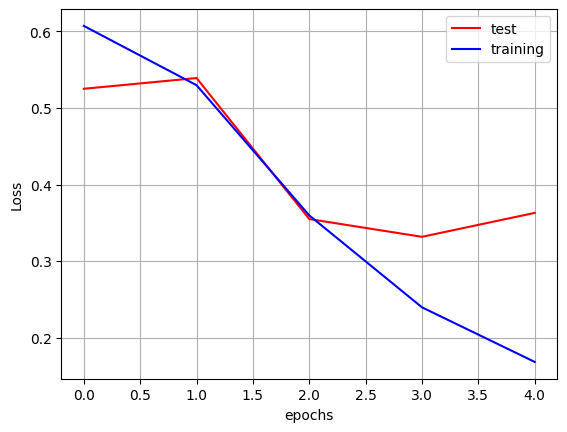

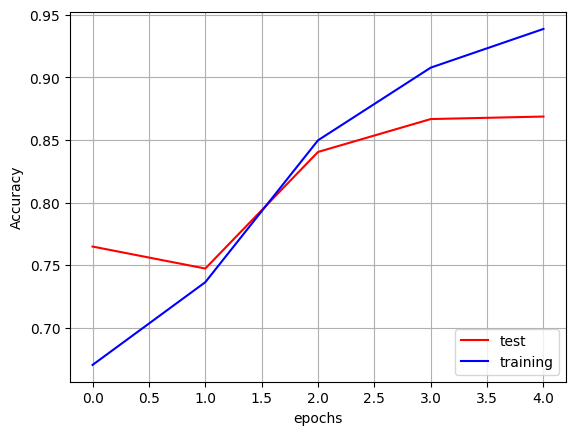

In [12]:
def plot_accuracy_and_loss(model):
    epochs = model.history.params['epochs']
    epochs = range(epochs)
    val_loss = model.history.history['val_loss']
    val_accuracy = model.history.history['val_accuracy']
    training_loss = model.history.history['loss']
    training_accuracy = model.history.history['accuracy']

    plt.plot(epochs, val_loss, 'r', label='test')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='test')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model)

In [28]:
def predict_sentiment(model, review):
  review = clean_review(review)
  review_tokens = tokenizer_obj.texts_to_sequences([review])
  review_pad = pad_sequences(review_tokens, maxlen=max_length, padding='post')
  prediction = model.predict(review_pad)
  if prediction > 0.5:
    prediction = "positive"
  else:
    prediction = "negative"
  return prediction


In [37]:
review = "This movie is terrible"
predict_sentiment(model, review)

1/1 [==============================] - 0s 19ms/step


'negative'

In [38]:
review = "This movie is great"
predict_sentiment(model, review)

1/1 [==============================] - 0s 19ms/step


'positive'

In [39]:
review = "a top notch movie"
predict_sentiment(model, review)

1/1 [==============================] - 0s 18ms/step


'positive'

In [41]:
review = "a horrible movie"
predict_sentiment(model, review)

1/1 [==============================] - 0s 46ms/step


'negative'

In [42]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
model.evaluate(X_train_pad, y_train)
model.evaluate(X_test_pad, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.3629 - accuracy: 0.8688


[0.3629473149776459, 0.8687999844551086]